# Análisis de Estrategia de Momentum Residual

Este notebook implementa y analiza la estrategia de Momentum Residual para acciones del NYSE.

In [5]:
import sys

sys.path.append("../src")

import random
from datetime import datetime, timedelta

import pandas as pd

from data_collection import get_fama_french_factors, get_stock_data
from preprocessing import calculate_returns
from strategy import (
    calculate_adjusted_residuals,
    calculate_residuals,
    create_portfolio,
    fit_ff_models,
)
from visualization import plot_adjusted_residuals, plot_prices

## 1. Recolección de Datos

In [6]:
# Cargar un archivo Excel que contiene datos de acciones
stocks_df = pd.read_excel('../data/stocks.xlsx', skiprows=1)

# Eliminar la primera columna del DataFrame
stocks_df = stocks_df.iloc[:, 1:]

# Mostrar las primeras filas del DataFrame resultante
stocks_df.head()

,Symbol,Exchange
0,VNET.O,NASDAQ
1,MMM,NYSE
2,ABT,NYSE
3,ABBV.K,NYSE
4,ACN,NYSE


In [7]:
# Definir período de análisis
end_date = datetime(2024, 3, 31)
start_date = end_date - timedelta(days=365*5)  # 5 años de datos

# Obtener lista de acciones del NYSE
stocks_df = stocks_df[stocks_df["Exchange"]=="NYSE"]

# Obtener una lista de símbolos de las acciones filtradas
nyse_stocks = stocks_df["Symbol"].str.replace('.K', '', regex=False).tolist()

# Descargar datos
stock_data = get_stock_data(nyse_stocks, start_date, end_date)
ff_factors = get_fama_french_factors(start_date, end_date)

[*********************100%***********************]  277 of 277 completed

17 Failed downloads:
['WWE', 'PTR', 'RAD', 'TWTR', 'HFC', 'PXD', 'BRKB', 'BFB', 'GOL', 'MBT', 'VMW', 'FLT', 'SFUN', 'CAJ', 'TTM', 'BSMX', 'ENIA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
c:\Users\Jonathan Diaz\Documentos\Proyects\Nueva carpeta\notebooks\../src\data_collection.py:18: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start=start_date, end=end_date)[0]
c:\Users\Jonathan Diaz\Documentos\Proyects\Nueva carpeta\notebooks\../src\data_collection.py:18: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_factor

In [8]:
# Calcular la proporción de acciones sin información disponible
missing_stocks = stock_data.isnull().sum() / len(stock_data)

# Listar las acciones que no se tendrán en cuenta para el análisis
missing_stocks = missing_stocks[missing_stocks == 1].index

# Definir lista de acciones con datos disponibles para el análisis
available_stocks = list(set(nyse_stocks) - set(missing_stocks))

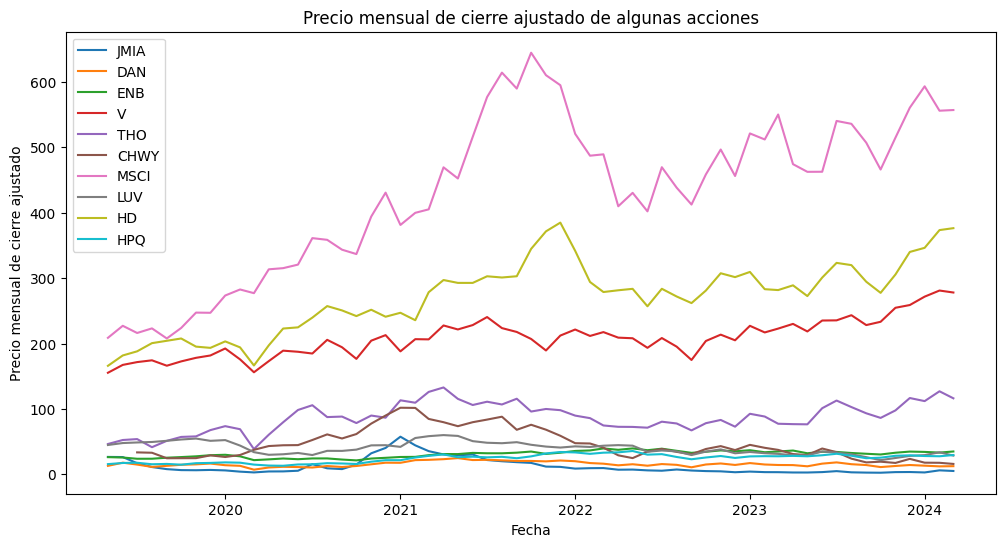

In [9]:
# Lista de símbolos de acciones
some_stocks = random.sample(available_stocks, 10)

plot_prices(some_stocks, stock_data)

## 2. Preprocesamiento de Datos

In [10]:
returns_df = calculate_returns(stock_data)

## 3. Implementación de la Estrategia

In [11]:
ff_models = fit_ff_models(returns_df, ff_factors, available_stocks)
residual_df = calculate_residuals(returns_df, ff_models, ff_factors, available_stocks)

In [13]:
risk_adjusted_residuals = calculate_adjusted_residuals(residual_df)
buy_assets, sell_assets = create_portfolio(risk_adjusted_residuals, top_pct=10, bottom_pct=10)
risk_adjusted_residuals.to_csv('../results/portfolio_performance.csv')

### 2.1 Portafolio

In [12]:
buy_assets

NVR      6.764213
TRV      7.042893
TM       7.539809
CB       7.595617
MUFG     7.903012
AIG      8.021970
ECL      8.083168
ITUB     8.282844
NOW      8.350461
HMC      8.402053
SMFG     8.835399
DLR      9.078423
PH       9.389937
DELL    10.276290
IBM     11.109896
GE      11.745092
UBER    12.721726
WFC     12.728989
MAC     12.949400
MFG     13.019338
MLM     13.536678
PNR     13.629176
LLY     13.706111
HLT     14.804893
TDG     20.630775
JPM     29.856767
dtype: float64

In [13]:
sell_assets

PFE    -44.833280
AMX    -35.110769
KO     -28.384738
STT    -22.632032
PM     -19.269756
MAA    -17.624162
ETR    -15.904199
ENB    -14.801951
UPS    -13.890470
EIX    -13.580058
MCD    -12.531976
BMY    -11.902264
LPL    -11.729517
ED     -11.373881
MO     -11.365633
AWK    -11.092975
KMB    -10.290196
BBY    -10.104498
ABEV    -9.971825
CPB     -9.695247
MGM     -9.369015
BNS     -8.979885
NKE     -7.966800
JNJ     -7.892484
GGB     -7.290168
HDB     -7.116820
dtype: float64

## 4. Análisis de Resultados

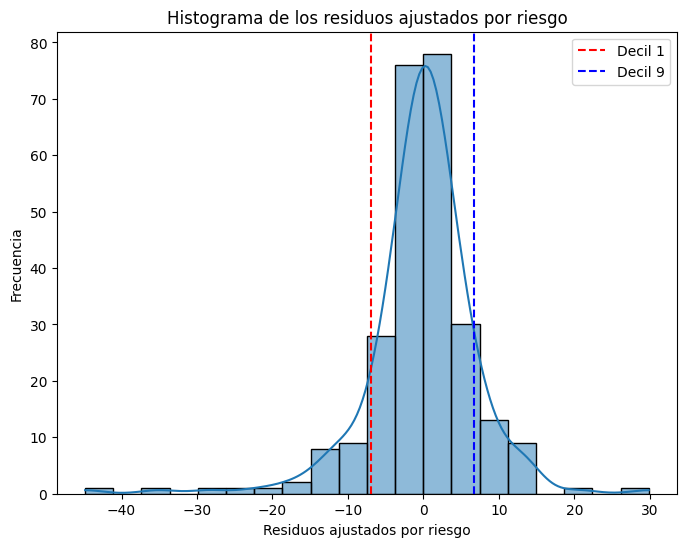

In [14]:
plot_adjusted_residuals(risk_adjusted_residuals)

## 5. Conclusiones

### Recomendaciones

Habiendo aplicado el método de Momentum Residual a los datos disponibles de las acciones del mercado de New York. Se sugiere que las acciones con residuos más altos podrían considerarse como candidatas para la compra, ya que el modelo sugiere que estas se ajustan mejor al modelo y tendrían menor riesgo. Por otro lado, las acciones con residuos más bajos podrían considerarse como candidatas para la venta ya que el modelo sugiere que el riesgo es mayor, las predicciones pueden alejarse del valor real.

### Acciones con mayores residuos ajustados por riesgo (Candidatos para la compra)

| Acción  | Residuo Ajustado por Riesgo |
|---------|-----------------------------|
|NVR      | 6.764213                    |
|TRV      | 7.042893                    |
|TM       | 7.539809                    |
|CB       | 7.595617                    |
|MUFG     | 7.903012                    |
|AIG      | 8.021970                    |
|ECL      | 8.083168                    |
|ITUB     | 8.282844                    |
|NOW      | 8.350461                    |
|HMC      | 8.402053                    |
|SMFG     | 8.835399                    |
|DLR      | 9.078423                    |
|PH       | 9.389937                    |
|DELL     | 10.276290                   |
|IBM      | 11.109896                   |
|GE       | 11.745092                   |
|UBER     | 12.721726                   |
|WFC      | 12.728989                   |
|MAC      | 12.949400                   |
|MFG      | 13.019338                   |
|MLM      | 13.536678                   |
|PNR      | 13.629176                   |
|LLY      | 13.706111                   |
|HLT      | 14.804893                   |
|TDG      | 20.630775                   |
|JPM      | 29.856767                   |

### Acciones con menores residuos ajustados por riesgo (Candidatos para la venta)

| Acción  | Residuo Ajustado por Riesgo |
|---------|-----------------------------|
| PFE     | -44.833280                  |
| AMX     | -35.110769                  |
| KO      | -28.384738                  |
| STT     | -22.632032                  |
| PM      | -19.269756                  |
| MAA     | -17.624162                  |
| ETR     | -15.904199                  |
| ENB     | -14.801951                  |
| UPS     | -13.890470                  |
| EIX     | -13.580058                  |
| MCD     | -12.531976                  |
| BMY     | -11.902264                  |
| LPL     | -11.729517                  |
| ED      | -11.373881                  |
| MO      | -11.365633                  |
| AWK     | -11.092975                  |
| KMB     | -10.290196                  |
| BBY     | -10.104498                  |
| ABEV    |  -9.971825                  |
| CPB     |  -9.695247                  |
| MGM     |  -9.369015                  |
| BNS     |  -8.979885                  |
| NKE     |  -7.966800                  |
| JNJ     |  -7.892484                  |
| GGB     |  -7.290168                  |
| HDB     |  -7.116820                  |